# Arbitrage Repair

In [1]:
import sys
import warnings

sys.path.append("..")
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set_theme()

import gleam as gm
import gleam.black_scholes as bs

## Construct arbitragable call prices 

In [2]:
spot = np.array([1])
strikes = np.array([
    [0.5, 0.8, 0.9, 1.0, 1.1, 1.2, 1.5], 
    [0.5, 0.6, 0.8, 1.0, 1.2, 1.4, 1.5]
])
tau = np.array([
    [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
    [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
])
sigma = np.array([1.0])

prices = bs.price(spot, strikes, tau, sigma)
prices_perturbed = prices.copy()
prices_perturbed[0, 3] = prices[0, 3] * 1.8
prices_perturbed[1, 4] = prices[1, 4] * 0.2

ivs = bs.iv(prices, spot, strikes, tau)
ivs_perturbed = bs.iv(prices_perturbed, spot, strikes, tau)

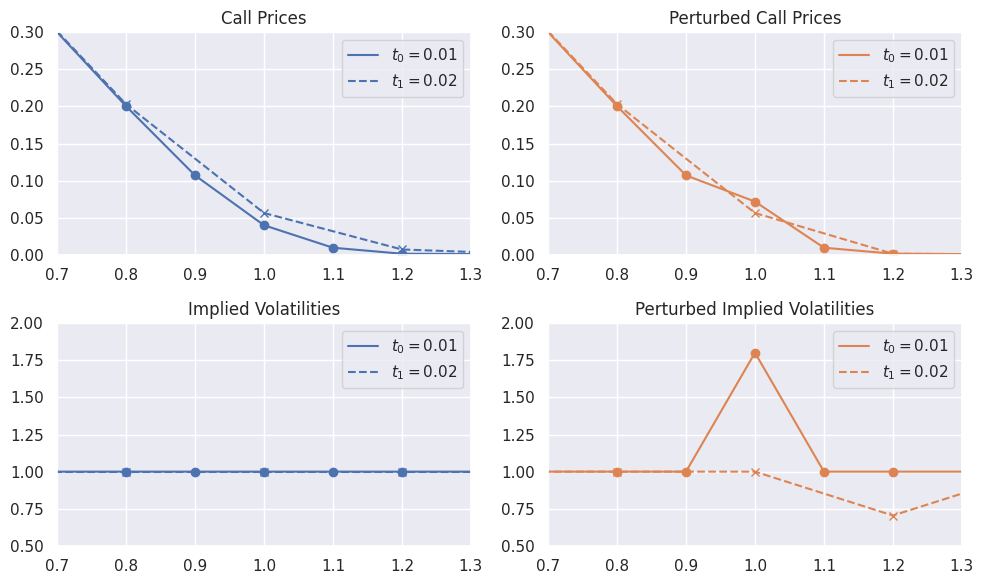

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

titles = [
    ["Call Prices", "Perturbed Call Prices"],
    ["Implied Volatilities", "Perturbed Implied Volatilities"]
]

data = [
    [prices, prices_perturbed],
    [ivs, ivs_perturbed]
]

ylims = [
    [0, 0.3],
    [0.5, 2]
]

for i in range(2):
    for j in range(2):
        color = f"C{j}"
        axes[i, j].plot(strikes[0], data[i][j][0], "-", color=color, label="$t_0=0.01$") 
        axes[i, j].plot(strikes[0], data[i][j][0], "o", color=color)
        axes[i, j].plot(strikes[1], data[i][j][1], "--", color=color, label="$t_1=0.02$")
        axes[i, j].plot(strikes[1], data[i][j][1], "x", color=color)
        axes[i, j].set_ylim(bottom=ylims[i][0], top=ylims[i][1])
        axes[i, j].set_xlim(0.7, 1.3)
        axes[i, j].legend()
        axes[i, j].set_title(titles[i][j])

plt.tight_layout()
plt.show()

## Calibrate DLVs 

In [4]:
dlv = gm.dlv.DiscreteLocalVolatilityModel()
dlv.calibrate(
    prices=prices_perturbed,
    strikes=strikes,
    maturities=tau, 
    bounds=np.array([
        [0.2, 1.6], 
        [0.2, 1.6]
    ])
)

## Retrieve prices after arbitrage repair 

In [5]:
prices_arb_free = dlv.get_prices(strikes, tau)
ivs_arb_free = bs.iv(prices_arb_free, spot, strikes, tau)

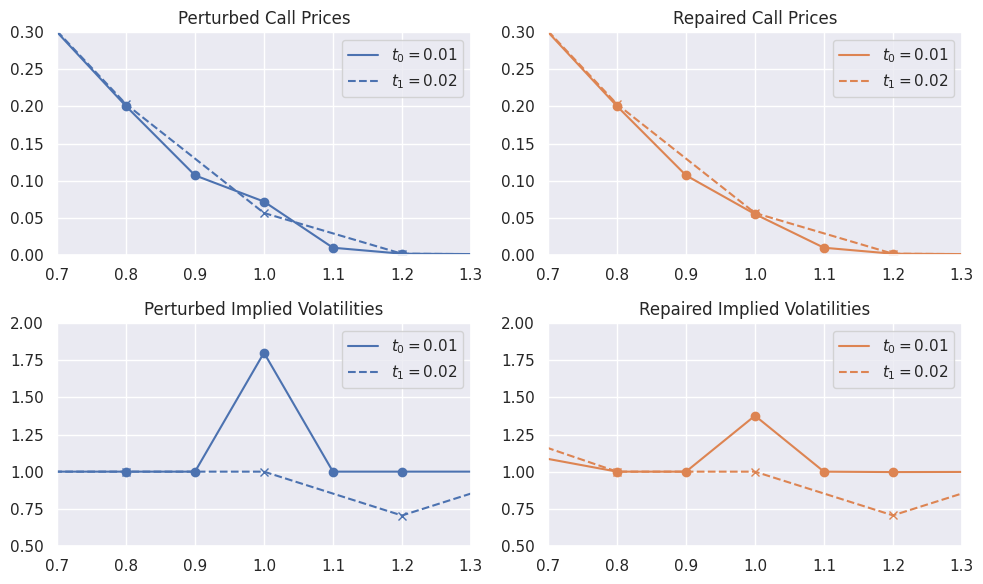

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

titles = [
    ["Perturbed Call Prices", "Repaired Call Prices"],
    ["Perturbed Implied Volatilities", "Repaired Implied Volatilities"]
]

data = [
    [prices_perturbed, prices_arb_free],
    [ivs_perturbed, ivs_arb_free]
]

ylims = [
    [0, 0.3],
    [0.5, 2]
]

for i in range(2):
    for j in range(2):
        color = f"C{j}"
        axes[i, j].plot(strikes[0], data[i][j][0], "-", color=color, label="$t_0=0.01$") 
        axes[i, j].plot(strikes[0], data[i][j][0], "o", color=color)
        axes[i, j].plot(strikes[1], data[i][j][1], "--", color=color, label="$t_1=0.02$")
        axes[i, j].plot(strikes[1], data[i][j][1], "x", color=color)
        axes[i, j].set_ylim(bottom=ylims[i][0], top=ylims[i][1])
        axes[i, j].set_xlim(0.7, 1.3)
        axes[i, j].legend()
        axes[i, j].set_title(titles[i][j])

plt.tight_layout()
plt.show()